In [4]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BusBreakdowns").getOrCreate()

# Read the file 
file = "sampled_data.csv"
df = spark.read.option("header", "true").csv(file)

print(f"Shape of data: ({df.count()}, {len(df.columns)})")
df.printSchema()

Shape of data: (10000, 21)
root
 |-- School_Year: string (nullable = true)
 |-- Busbreakdown_ID: string (nullable = true)
 |-- Run_Type: string (nullable = true)
 |-- Bus_No: string (nullable = true)
 |-- Route_Number: string (nullable = true)
 |-- Reason: string (nullable = true)
 |-- Schools_Serviced: string (nullable = true)
 |-- Occurred_On: string (nullable = true)
 |-- Created_On: string (nullable = true)
 |-- Boro: string (nullable = true)
 |-- Bus_Company_Name: string (nullable = true)
 |-- How_Long_Delayed: string (nullable = true)
 |-- Number_Of_Students_On_The_Bus: string (nullable = true)
 |-- Has_Contractor_Notified_Schools: string (nullable = true)
 |-- Has_Contractor_Notified_Parents: string (nullable = true)
 |-- Have_You_Alerted_OPT: string (nullable = true)
 |-- Informed_On: string (nullable = true)
 |-- Incident_Number: string (nullable = true)
 |-- Last_Updated_On: string (nullable = true)
 |-- Breakdown_or_Running_Late: string (nullable = true)
 |-- School_Age_or_P

In [5]:
from pyspark.sql.functions import when, col
missing_data = df.selectExpr([f'sum(if({c} is null, 1, 0)) as {c}' for c in df.columns])
missing_data.show()

+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------+-------------------------+------------------+
|School_Year|Busbreakdown_ID|Run_Type|Bus_No|Route_Number|Reason|Schools_Serviced|Occurred_On|Created_On|Boro|Bus_Company_Name|How_Long_Delayed|Number_Of_Students_On_The_Bus|Has_Contractor_Notified_Schools|Has_Contractor_Notified_Parents|Have_You_Alerted_OPT|Informed_On|Incident_Number|Last_Updated_On|Breakdown_or_Running_Late|School_Age_or_PreK|
+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------

In [6]:
from pyspark.sql.functions import when, col
delay_time_category = ['16-30 Min', '31-45 Min', '0-15 Min', '46-60 Min', '61-90 Min']
df = df.filter(df['How_Long_Delayed'].isin(delay_time_category)).withColumn("How_Long_Delayed", when(
    col("How_Long_Delayed").isin(delay_time_category) | col("How_Long_Delayed").isNotNull(), 
    col("How_Long_Delayed")).otherwise("91-Inf Min"))
df.groupBy("How_Long_Delayed").count().show()

columns_to_drop_na = ['Run_Type', 'Reason', 'Boro', 'School_Age_or_PreK']
df = df.dropna(subset=columns_to_drop_na)

missing_data = df.selectExpr([f'sum(if({c} is null, 1, 0)) as {c}' for c in df.columns])
missing_data.show()

+----------------+-----+
|How_Long_Delayed|count|
+----------------+-----+
|        0-15 Min|  967|
|       16-30 Min| 2599|
|       31-45 Min| 3004|
|       46-60 Min| 1732|
|       61-90 Min|  943|
+----------------+-----+

+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------+-------------------------+------------------+
|School_Year|Busbreakdown_ID|Run_Type|Bus_No|Route_Number|Reason|Schools_Serviced|Occurred_On|Created_On|Boro|Bus_Company_Name|How_Long_Delayed|Number_Of_Students_On_The_Bus|Has_Contractor_Notified_Schools|Has_Contractor_Notified_Parents|Have_You_Alerted_OPT|Informed_On|Incident_Number|Last_Updated_On|Breakdown_or_Running_Late|School_Age_or_PreK|
+-----------+---------------+--------+------+------------+------+-----------

In [7]:
column_name = 'Number_Of_Students_On_The_Bus'
df.select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9243|
|   mean|           3.3417721518987342|
| stddev|            97.23426454195086|
|    min|                            0|
|    max|                         9034|
+-------+-----------------------------+



In [8]:
column_name = 'Number_Of_Students_On_The_Bus'
df.select(column_name).describe().show()
df.filter(df[column_name]<100).select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9243|
|   mean|           3.3417721518987342|
| stddev|            97.23426454195086|
|    min|                            0|
|    max|                         9034|
+-------+-----------------------------+

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9237|
|   mean|           1.8448630507740609|
| stddev|            3.701987116836907|
|    min|                            0|
|    max|                            9|
+-------+-----------------------------+



In [11]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

mean_value = df.agg({'Number_Of_Students_On_The_Bus': 'mean'}).collect()[0][0]
stddev_value = df.agg({'Number_Of_Students_On_The_Bus': 'stddev'}).collect()[0][0]

df = df.withColumn('z_scores', (df['Number_Of_Students_On_The_Bus'] - mean_value) / stddev_value)
df = df.filter((df['Number_Of_Students_On_The_Bus'] < 100) & (df['z_scores'] < 5))
df.select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                         9201|
|   mean|            1.732094337572003|
| stddev|           3.1971218806600255|
|    min|                            0|
|    max|                            9|
+-------+-----------------------------+



In [12]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import date_format

df = df.withColumn('Occurred_On', to_timestamp(df['Occurred_On'], 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn('Occurred_On', df['Occurred_On'].cast(TimestampType()))
df.select('Occurred_On', date_format('Occurred_On', 'MM/dd/yyyy hh:mm:ss a').alias('Formatted_Occurred_On')).show()

+-------------------+---------------------+
|        Occurred_On|Formatted_Occurred_On|
+-------------------+---------------------+
|2022-10-12 15:22:00| 10/12/2022 03:22:...|
|2023-04-17 14:20:00| 04/17/2023 02:20:...|
|2020-01-24 15:23:00| 01/24/2020 03:23:...|
|2021-10-07 15:20:00| 10/07/2021 03:20:...|
|2018-10-03 07:25:00| 10/03/2018 07:25:...|
|2021-04-08 07:52:00| 04/08/2021 07:52:...|
|2022-10-13 08:20:00| 10/13/2022 08:20:...|
|2022-09-28 06:03:00| 09/28/2022 06:03:...|
|2021-05-28 08:52:00| 05/28/2021 08:52:...|
|2023-05-03 06:45:00| 05/03/2023 06:45:...|
|2022-02-07 07:30:00| 02/07/2022 07:30:...|
|2022-10-06 14:55:00| 10/06/2022 02:55:...|
|2019-12-20 06:43:00| 12/20/2019 06:43:...|
|2022-10-12 09:00:00| 10/12/2022 09:00:...|
|2021-10-15 07:00:00| 10/15/2021 07:00:...|
|2023-02-28 13:33:00| 02/28/2023 01:33:...|
|2019-11-22 07:33:00| 11/22/2019 07:33:...|
|2018-09-12 04:10:00| 09/12/2018 04:10:...|
|2023-03-16 05:20:00| 03/16/2023 05:20:...|
|2021-11-22 07:01:00| 11/22/2021

In [13]:
from pyspark.sql.functions import hour, dayofweek, month
import matplotlib.pyplot as plt

# Derive new columns
df = df.withColumn("Occurred_On_Hour", hour("Occurred_On"))
df = df.withColumn("Occurred_On_DayOfWeek", (dayofweek("Occurred_On") - 1).cast("integer"))
df = df.withColumn("Occurred_On_Month", month("Occurred_On"))

+----------------+-----+
|Occurred_On_Hour|Count|
+----------------+-----+
|               0|   20|
|               1|   11|
|               2|   20|
|               3|    8|
|               4|    4|
|               5|  355|
|               6| 2839|
|               7| 3132|
|               8|  748|
|               9|   62|
|              10|   14|
|              11|   21|
|              12|   59|
|              13|  799|
|              14|  811|
|              15|  244|
|              16|   42|
|              17|   12|
+----------------+-----+



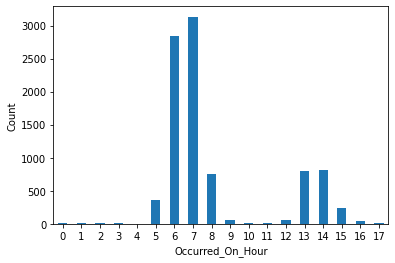

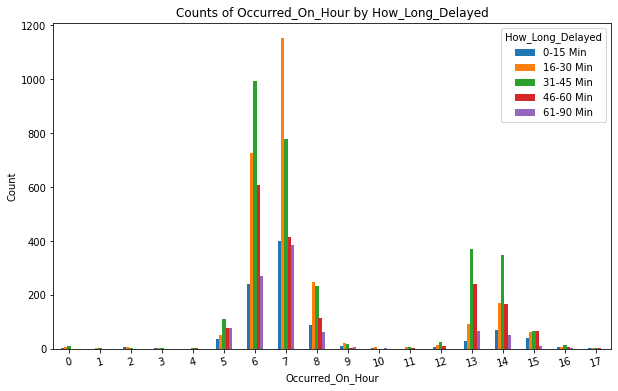

+---------------------+-----+
|Occurred_On_DayOfWeek|Count|
+---------------------+-----+
|                    1| 1827|
|                    2| 1862|
|                    3| 1881|
|                    4| 1869|
|                    5| 1762|
+---------------------+-----+



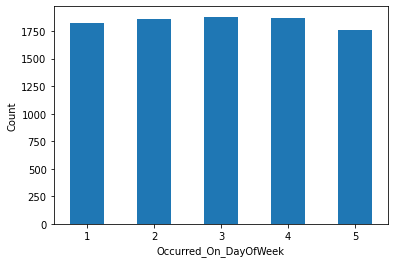

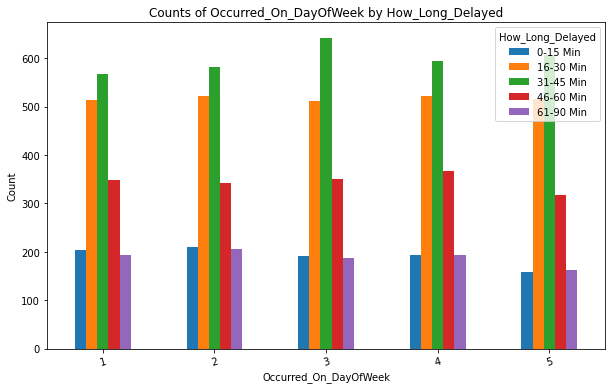

+-----------------+-----+
|Occurred_On_Month|Count|
+-----------------+-----+
|                1| 1015|
|                2|  861|
|                3|  966|
|                4|  634|
|                5|  884|
|                6|  489|
|                9|  863|
|               10| 1401|
|               11| 1196|
|               12|  892|
+-----------------+-----+



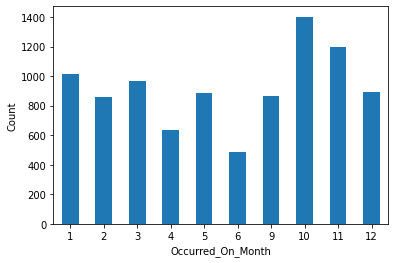

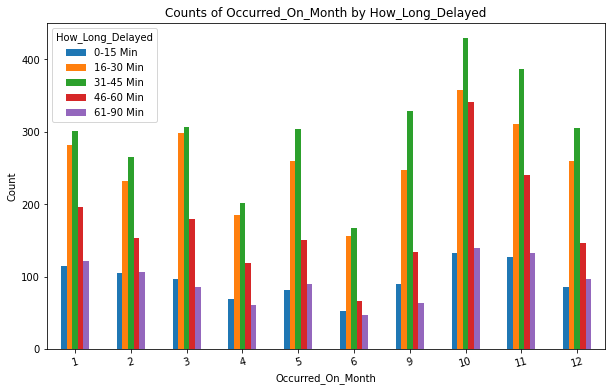

In [14]:
# Visualize the data
colname_time_new = ['Occurred_On_Hour', 'Occurred_On_DayOfWeek', 'Occurred_On_Month']
df.createOrReplaceTempView("bus_data")
for item in colname_time_new:
    result = spark.sql(f"SELECT {item}, COUNT(*) AS Count FROM bus_data GROUP BY {item} ORDER BY {item}")
    result.show()
    
    data = result.toPandas()
    data.plot(kind='bar', x=item, y='Count', legend=False)
    plt.ylabel('Count')
    plt.xlabel(item)
    plt.xticks(rotation=0)
    plt.show()
    
    data = df.groupBy(item, 'How_Long_Delayed').count().orderBy('How_Long_Delayed')
    pivot_df = data.toPandas().pivot(index=item, columns='How_Long_Delayed', values='count')
    pivot_df.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Count')
    plt.xlabel(item)
    plt.xticks(rotation=15)
    plt.title(f'Counts of {item} by How_Long_Delayed')
    plt.show()

In [15]:
from pyspark.sql.types import IntegerType
df = df.withColumn("Number_Of_Students_On_The_Bus", df["Number_Of_Students_On_The_Bus"].cast(IntegerType()))
# Select specific columns
selected_columns = ['School_Year', 'Run_Type', 'Reason', 'Boro', 'Bus_Company_Name',
                    'School_Age_or_PreK', 'Number_Of_Students_On_The_Bus', 'Occurred_On_Hour',
                    'Occurred_On_Month', 'How_Long_Delayed', 'Has_Contractor_Notified_Schools',
                    'Has_Contractor_Notified_Parents', 'Have_You_Alerted_OPT']

df = df.select(selected_columns)

# Show DataFrame info
df.printSchema()

# Save the DataFrame to a CSV file
df.write.csv('cleaned.csv', header=True, mode='overwrite')

root
 |-- School_Year: string (nullable = true)
 |-- Run_Type: string (nullable = true)
 |-- Reason: string (nullable = true)
 |-- Boro: string (nullable = true)
 |-- Bus_Company_Name: string (nullable = true)
 |-- School_Age_or_PreK: string (nullable = true)
 |-- Number_Of_Students_On_The_Bus: integer (nullable = true)
 |-- Occurred_On_Hour: integer (nullable = true)
 |-- Occurred_On_Month: integer (nullable = true)
 |-- How_Long_Delayed: string (nullable = true)
 |-- Has_Contractor_Notified_Schools: string (nullable = true)
 |-- Has_Contractor_Notified_Parents: string (nullable = true)
 |-- Have_You_Alerted_OPT: string (nullable = true)



In [7]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BusBreakdowns").getOrCreate()

# Read the file 
file = "cleaned.csv"
df = spark.read.option("header", "true").csv(file)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, log
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F


df = df.withColumn('How_Long_Delayed', when(df['How_Long_Delayed'] == '0-15 Min', 15)
                                   .when(df['How_Long_Delayed'] == '16-30 Min', 30)
                                   .when(df['How_Long_Delayed'] == '31-45 Min', 45)
                                   .when(df['How_Long_Delayed'] == '46-60 Min', 60)
                                   .when(df['How_Long_Delayed'] == '61-90 Min', 90)
                                   .when(df['How_Long_Delayed'] == '91-Inf Min', 360)
                                   .otherwise(df['How_Long_Delayed']).cast(DoubleType()))

+-------+-----------------+
|summary| How_Long_Delayed|
+-------+-----------------+
|  count|             9201|
|   mean|45.08151287903489|
| stddev|20.15116477737358|
|    min|             15.0|
|    max|             90.0|
+-------+-----------------+



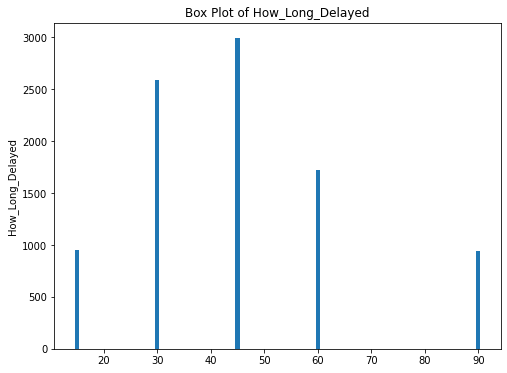

In [9]:
df.select('How_Long_Delayed').describe().show()

counts = df.groupBy('How_Long_Delayed').agg(F.count('*').alias('Count'))
counts_pandas = counts.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(counts_pandas['How_Long_Delayed'], counts_pandas['Count'])
plt.ylabel('How_Long_Delayed')
plt.title('Box Plot of How_Long_Delayed')
plt.show()

In [10]:
df = df.withColumn('How_Long_Delayed', log(df['How_Long_Delayed']))

+-------+------------------+
|summary|  How_Long_Delayed|
+-------+------------------+
|  count|              9201|
|   mean| 3.703379906828375|
| stddev|0.4749949512108136|
|    min|  2.70805020110221|
|    max| 4.499809670330265|
+-------+------------------+



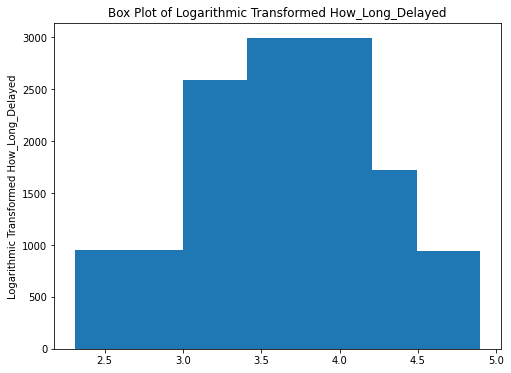

In [11]:
df.select('How_Long_Delayed').describe().show()

counts = df.groupBy('How_Long_Delayed').agg(F.count('*').alias('Count'))
counts_pandas = counts.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(counts_pandas['How_Long_Delayed'], counts_pandas['Count'])
plt.ylabel('Logarithmic Transformed How_Long_Delayed')
plt.title('Box Plot of Logarithmic Transformed How_Long_Delayed')
plt.show()

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import SparkSession

# List of categorical columns
categorical_columns = ['School_Year', 'Run_Type', 'Reason', 'Boro','Number_Of_Students_On_The_Bus', 'Occurred_On_Hour', 'Occurred_On_Month',
                       'Bus_Company_Name', 'School_Age_or_PreK',
                       'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents',
                       'Have_You_Alerted_OPT']

stages = []

for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded")
    stages += [indexer, encoder]

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
model = pipeline.fit(df)
df = model.transform(df)

In [13]:
# Define the target column
target_column = 'How_Long_Delayed'

# Define a list of groups of features
feature_groups = [
    ['School_Year_encoded', 'Number_Of_Students_On_The_Bus_encoded', 'Occurred_On_Hour_encoded', 'Occurred_On_Month_encoded'],
    ['Run_Type_encoded', 'Reason_encoded', 'Boro_encoded', 'Bus_Company_Name_encoded'],
    ['School_Age_or_PreK_encoded', 'Has_Contractor_Notified_Schools_encoded', 'Has_Contractor_Notified_Parents_encoded', 'Have_You_Alerted_OPT_encoded']
]

for i, group in enumerate(feature_groups):
    sub_df = df.select(group + [target_column])

    feature_assembler = VectorAssembler(inputCols=group, outputCol="features")
    sub_df = feature_assembler.transform(sub_df)

    lr = LinearRegression(featuresCol="features", labelCol=target_column)
    lr_model = lr.fit(sub_df)

    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(lr_model.transform(sub_df))
    r2 = evaluator.evaluate(lr_model.transform(sub_df), {evaluator.metricName: "r2"})

    print(f"Model for group {i + 1} features:")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}\n")  

23/10/12 17:53:45 WARN Instrumentation: [4111d975] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:53:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/12 17:53:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/12 17:53:47 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/10/12 17:53:47 WARN Instrumentation: [4111d975] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Model for group 1 features:
Root Mean Squared Error (RMSE): 0.455825014899164
R-squared (R2): 0.07898749660487492



23/10/12 17:53:51 WARN Instrumentation: [ab7efe63] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:53:51 WARN Instrumentation: [ab7efe63] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Model for group 2 features:
Root Mean Squared Error (RMSE): 0.3472469367823476
R-squared (R2): 0.4655020263741063



23/10/12 17:53:53 WARN Instrumentation: [2554234c] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:53:54 WARN Instrumentation: [2554234c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Model for group 3 features:
Root Mean Squared Error (RMSE): 0.46754756874053943
R-squared (R2): 0.031006592396392807



In [18]:
selected_columns = ['How_Long_Delayed', 'Run_Type_encoded', 'Reason_encoded', 'Boro_encoded', 'Bus_Company_Name_encoded']

df = df.select(selected_columns)

# Show DataFrame info
df.printSchema()

root
 |-- How_Long_Delayed: double (nullable = true)
 |-- Run_Type_encoded: vector (nullable = true)
 |-- Reason_encoded: vector (nullable = true)
 |-- Boro_encoded: vector (nullable = true)
 |-- Bus_Company_Name_encoded: vector (nullable = true)



In [19]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Create a new DataFrame with extracted features
def extract_feature_vector(vector):
    return Vectors.dense(vector.toArray())

extract_feature_vector_udf = udf(extract_feature_vector, DoubleType())

df = df.withColumn("Run_Type_feature", extract_feature_vector_udf(df["Run_Type_encoded"]))
df = df.withColumn("Reason_feature", extract_feature_vector_udf(df["Reason_encoded"]))
df = df.withColumn("Boro_feature", extract_feature_vector_udf(df["Boro_encoded"]))
df = df.withColumn("Bus_Company_Name_feature", extract_feature_vector_udf(df["Bus_Company_Name_encoded"]))

# Select columns for the GLM model
selected_columns = ['How_Long_Delayed', 'Run_Type_feature', 'Reason_feature', 'Boro_feature', 'Bus_Company_Name_feature']
glm_data = df.select(selected_columns)

# Define the features column
features_col = ["Run_Type_feature", "Reason_feature", "Boro_feature", "Bus_Company_Name_feature"]

# Create a GLM model
glm = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="How_Long_Delayed",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

# Fit the GLM model
glm_model = glm.fit(glm_data)

# View the summary of the GLM model
print(glm_model.summary)


IllegalArgumentException: features does not exist. Available: How_Long_Delayed, Run_Type_feature, Reason_feature, Boro_feature, Bus_Company_Name_feature

In [ ]:
df.printSchema()